# Imports and Setups

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

#import constants from grid.yp
from grid import *

#set parameters for prettier plots
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

# Load Point Of Interest

In [2]:
POIS = {}

with open("pois.csv", newline="") as pois_csv:
    pois_r = csv.reader(pois_csv, delimiter=" ")
    pois_h = next(pois_r)
    for row in pois_r:
        poi_id, cell_id, poi_type, lat, lon = row
        poi_id, cell_id = int(poi_id), int(cell_id)
        lat, lon = float(lat), float(lon)
        if poi_type not in POIS.keys():
            POIS[poi_type] = [(poi_id, cell_id, lat, lon)]
        else:
            POIS[poi_type].append((poi_id, cell_id, lat, lon))

# Load Users Queries

In [3]:
QUERIES = {}

with open("queries.csv", newline="") as queries_csv:
    queries_r = csv.reader(queries_csv, delimiter=" ")
    queries_h = next(queries_r)
    for row in queries_r:
        ip_address, lat, lon, timestamp, poi_query_type = row
        lat, lon, timestamp = float(lat), float(lon), float(timestamp)
        if ip_address not in QUERIES.keys():
            QUERIES[ip_address] = [(lat, lon, timestamp, poi_query_type)]
        else:
            QUERIES[ip_address].append((lat, lon, timestamp, poi_query_type))

# Plots

## Draw map

In [4]:
def draw_map():
    x = np.linspace(MAP_LAT, MAP_LAT+MAP_SIZE_LAT, CELL_NUM_LAT+1)
    y = np.linspace(MAP_LON, MAP_LON+MAP_SIZE_LON, CELL_NUM_LON+1)

    fig = plt.figure().add_subplot()

    plt.axis([MAP_LAT, MAP_LAT+MAP_SIZE_LAT, MAP_LON, MAP_LON+MAP_SIZE_LON])
    plt.xticks(x)
    plt.yticks(y)

    x_labels = fig.get_xticks().tolist()
    x_labels_new = [round(x_labels[i],2) if (i == 0 or i == CELL_NUM_LAT) else "" for i in range(len(x_labels))]
    fig.set_xticklabels(x_labels_new)

    y_labels = fig.get_yticks().tolist()
    y_labels_new = [round(y_labels[i],2) if (i == 0 or i == CELL_NUM_LON) else "" for i in range(len(y_labels))]
    fig.set_yticklabels(y_labels_new)

    plt.xlabel("latitude")
    plt.ylabel("longitude")

    plt.grid(True)
    
    return fig

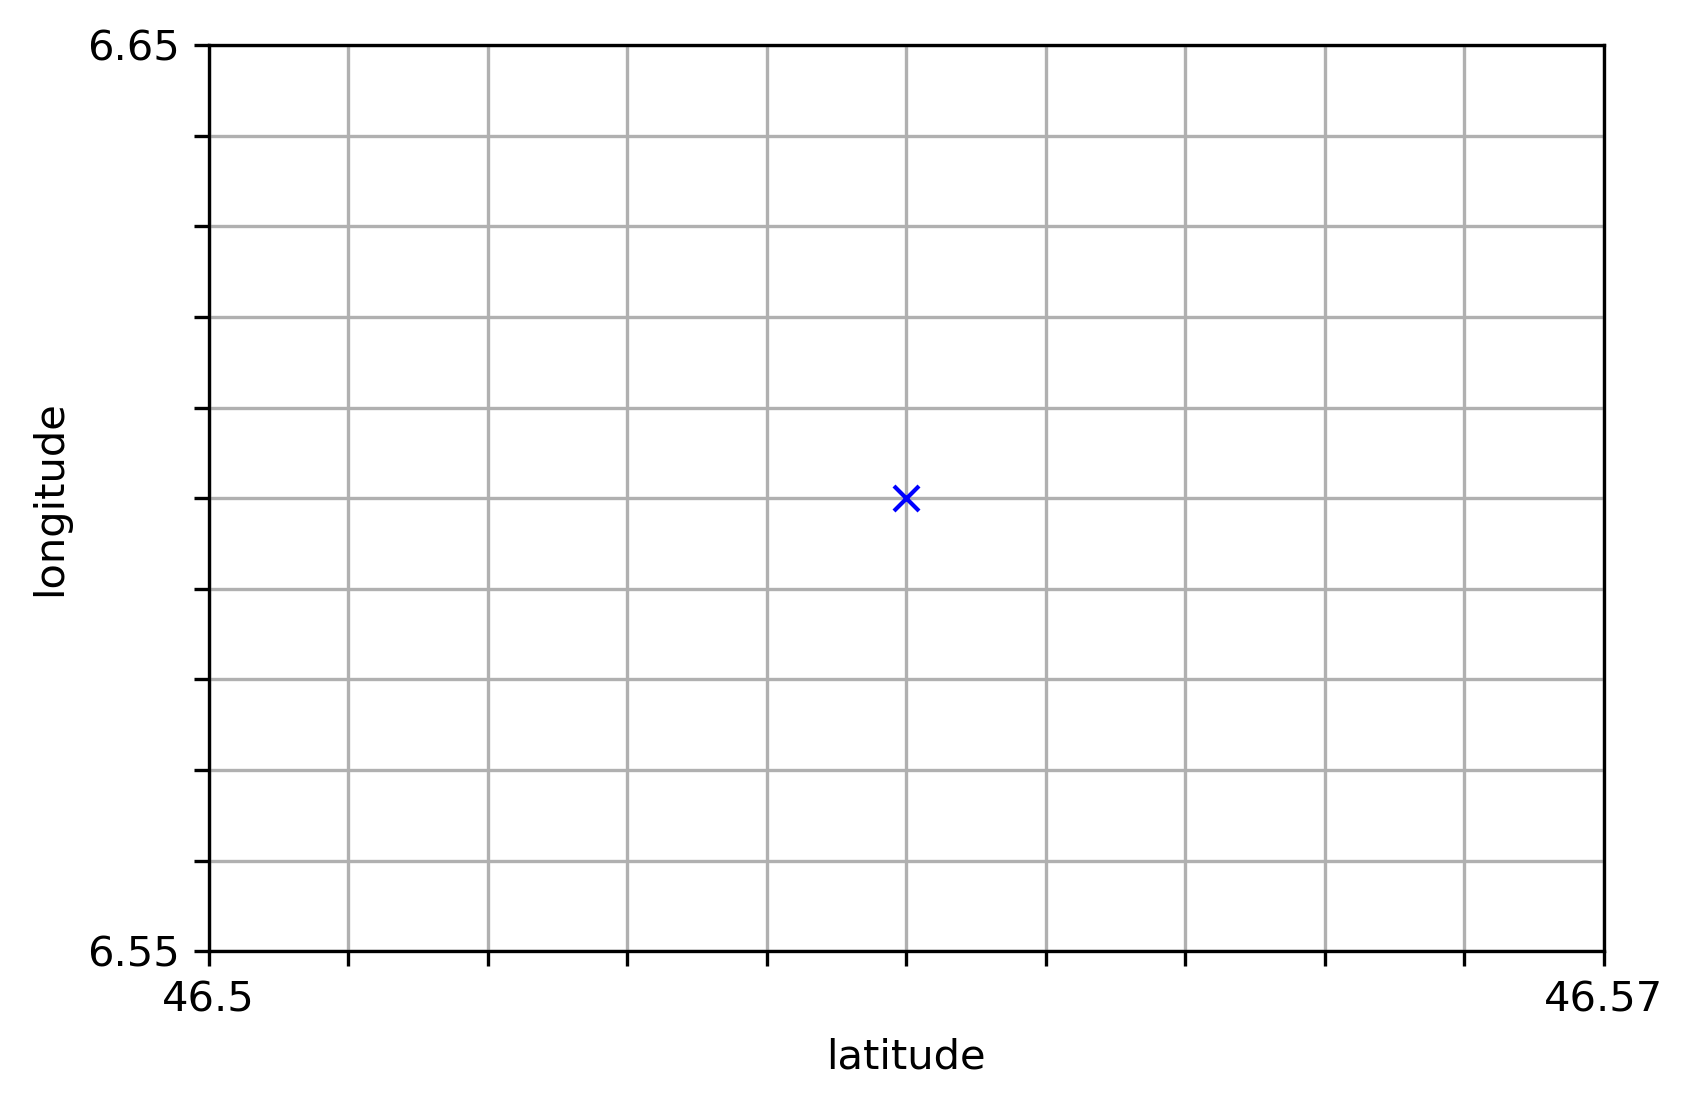

In [5]:
fig = draw_map()
plt.plot(46.535, 6.60, "bx")
plt.show()